In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
import subprocess
%matplotlib inline

##### some useful sites:
* http://research.jisao.washington.edu/data_sets/nco/
* http://nco.sourceforge.net/nco.html

### Start from Jan 1, 2015

In [2]:
#for yr in ('15','16','17'): # years
yr='16'
fdec=glob.glob('/results/SalishSea/nowcast-green/*dec'+'15'+'/SalishSea_1d*_grid_T.nc')
fjan=glob.glob('/results/SalishSea/nowcast-green/*jan'+yr+'/SalishSea_1d*_grid_T.nc')
ffeb=glob.glob('/results/SalishSea/nowcast-green/*feb'+yr+'/SalishSea_1d*_grid_T.nc')
fmar=glob.glob('/results/SalishSea/nowcast-green/*mar'+yr+'/SalishSea_1d*_grid_T.nc')
fapr=glob.glob('/results/SalishSea/nowcast-green/*apr'+yr+'/SalishSea_1d*_grid_T.nc')
fmay=glob.glob('/results/SalishSea/nowcast-green/*may'+yr+'/SalishSea_1d*_grid_T.nc')
fjun=glob.glob('/results/SalishSea/nowcast-green/*jun'+yr+'/SalishSea_1d*_grid_T.nc')
fjul=glob.glob('/results/SalishSea/nowcast-green/*jul'+yr+'/SalishSea_1d*_grid_T.nc')
faug=glob.glob('/results/SalishSea/nowcast-green/*aug'+yr+'/SalishSea_1d*_grid_T.nc')
fsep=glob.glob('/results/SalishSea/nowcast-green/*sep'+yr+'/SalishSea_1d*_grid_T.nc')
foct=glob.glob('/results/SalishSea/nowcast-green/*oct'+yr+'/SalishSea_1d*_grid_T.nc')
fnov=glob.glob('/results/SalishSea/nowcast-green/*nov'+yr+'/SalishSea_1d*_grid_T.nc')

In [3]:
fJFM=fdec+fjan+ffeb
fAMJ=fmar+fapr+fmay
fJAS=fjun+fjul+faug
fOND=fsep+foct+fnov

In [4]:
# index 21 is 28.229916 m
foutJFM='/data/vdo/MEOPAR/for-devin/meanDJF_0-30m_20'+yr+'.nc'
%time subprocess.check_output('ncra -v votemper,vosaline -d deptht,,21,1 '+' '.join(fJFM)+' '+foutJFM,shell=True)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1min 2s


b''

In [5]:
# index 21 is 28.229916 m
foutAMJ='/data/vdo/MEOPAR/for-devin/meanMAM_0-30m_20'+yr+'.nc'
%time subprocess.check_output('ncra -v votemper,vosaline -d deptht,,21,1 '+' '.join(fAMJ)+' '+foutAMJ,shell=True)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 53.4 s


b''

In [6]:
# index 21 is 28.229916 m
foutJAS='/data/vdo/MEOPAR/for-devin/meanJJA_0-30m_20'+yr+'.nc'
%time subprocess.check_output('ncra -v votemper,vosaline -d deptht,,21,1 '+' '.join(fJAS)+' '+foutJAS,shell=True)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1min 43s


b''

In [7]:
# index 21 is 28.229916 m
foutOND='/data/vdo/MEOPAR/for-devin/meanSON_0-30m_20'+yr+'.nc'
%time subprocess.check_output('ncra -v votemper,vosaline -d deptht,,21,1 '+' '.join(fOND)+' '+foutOND,shell=True)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 57 s


b''

### Now combine seasonal averages in 1 file
* there maybe be a way to create the averages and combine them all in one step, maybe using hyperslabs and/or subcycle features, but this may require even day divisions (months do not have the same number of days
* you can only concatenate along the "record dimension", typically unlimited dimension. If you download from ERDDAP, you have to make time a record dimesion

In [8]:
fout='/data/vdo/MEOPAR/for-devin/seasonal-30_20'+yr+'.nc'
flist=foutJFM+' '+foutAMJ+' '+foutJAS+' '+foutOND
%time subprocess.check_output('ncrcat '+flist+' '+fout,shell=True)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.74 s


b''

In [9]:
f=nc.Dataset(fout)

In [10]:
f.variables.keys()

odict_keys(['bounds_lat', 'bounds_lon', 'deptht', 'deptht_bounds', 'nav_lat', 'nav_lon', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'vosaline', 'votemper'])

In [11]:
f.variables['deptht'][-1]

28.229916

In [12]:
[dt.datetime(1900,1,1)+dt.timedelta(seconds=ii) for ii in f.variables['time_centered']]

[datetime.datetime(2016, 1, 15, 12, 0),
 datetime.datetime(2016, 4, 16, 0, 0),
 datetime.datetime(2016, 7, 17, 0, 0),
 datetime.datetime(2016, 10, 16, 12, 0)]

#### strange that 3rd quarter ends on 9/5?

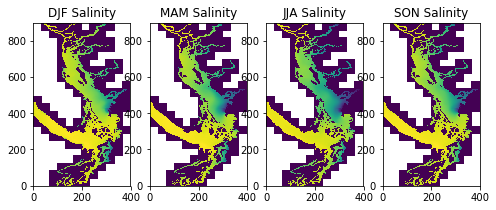

In [13]:
fig,ax=plt.subplots(1,4,figsize=(8,3))
ax[0].pcolormesh(f.variables['vosaline'][0,0,:,:])
ax[0].set_title('DJF Salinity')
ax[1].pcolormesh(f.variables['vosaline'][1,0,:,:])
ax[1].set_title('MAM Salinity')
ax[2].pcolormesh(f.variables['vosaline'][2,0,:,:])
ax[2].set_title('JJA Salinity')
ax[3].pcolormesh(f.variables['vosaline'][3,0,:,:])
ax[3].set_title('SON Salinity')

In [14]:
f.close()

#### to calculate for deepest cell:
* use bathy file to create mask that selects out the deepest ocean bin at each depth
* concatenate masks together to appropriate length to for each season
* concatenate season files together
* add mask file to concatenated file using ncks -A
* multiply T and S by mask using NCAP2
* use ncra with appropriate flags to sum over depth
* use ncra to average in time